# GNN GCN Explainer

The goal of this notebook is to walk through Graph Convolutional Networks (GCNs) flavor of a GNN (graph neural network). Like CNNs on images, GCNs operate on graphs where nodes are entities  and edges encode relations. A standard GCN layer does two things: it aggregates normalized messages from each node’s neighbors (using the graph’s adjacency) and mixes features with a shared linear transform. Stacking more layers lets information flow across more hops (think 2 connections apart). This makes GCNs effective for node classification, link prediction, and graph classification. In this notebook we'll actually focus on a specific variang called a signed GCNs since it allows for edges to have both positive and negative relationships while keeping the same message-passing idea. Common GNN pitfalls include over-smoothing through the use of deep layers that make nodes look alike, over-squashing that creates long-range info bottlenecked, and numerical issues on irregular/signed graphs. We'll address some fixes to these in our examples. 

To help display how GCNs work, we'll use a representation of a gene regulatory network where we have 2 specific cell types, a set of genes that are up/down regulated, and then a label for each sample to flag if it's cancerous or not. With our GCN, the goal will be to train it to take in a set of genes and how they're regulated and then predict the cell type as the *node task*, or node level prediction and whether it's cancerous as the *graph task* or graph level prediction. This dual goal will require us to balance 2 loss functions. 

## Graph Data Prep

We'll start with a common preprocessing step. Instead of a typical tokenizer, we have to create a numerical representation of our graph by enumerating the ndes and edges.  This process first starts by creating a series of "token-like" IDS vor our node vocabulary. In our example that becomes the gene and cell types.  We then use integers to map the relationship of the gene and cell types. This is where our **signed graph** starts since we use a `+1` edges for up-regulation and `-1` for down-regulation.   As a result we end up with the following generated:
1. **x_tokens** - a list of nodes
2. **y_node** - per-node (gene) gene cell type labels. This uses a balance of the up regulated and down-regulate genes and flags for each sample if the gene is more common with B-cells or T-cells.  We use a `-1` here to flag cells to ignore
3. **y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for wild type
4. **a_list** - the nodes in our graph that link the different cell types and genes together.  We pool together all the samples together into a large block-diagonal matrix.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
cell_types = ["Tcells","Bcells"]
genes = ['CD3D','LCK','ZAP70','CD19'] #only focused on genes present
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
gene_mask = torch.tensor([1,1,1,1,0,0], dtype=torch.bool)
N = len(node_order) 

In [3]:
wild_type = {
    'Tcells':{'up': ['CD3D','LCK','ZAP70'],'down': ['CD19']},
    'Bcells':{'up': ['CD19'],'down': ['CD3D','LCK','ZAP70']},
  #  'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
    'Tcells':{'up': ['CD3D','ZAP70'],'down': ['CD19','LCK']},
    'Bcells':{'up': ['CD19','LCK','CD3D'],'down': ['ZAP70']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_2 = {
    'Tcells':{'up': ['ZAP70'],'down': ['CD19','CD3D','LCK']},
    'Bcells':{'up': ['CD19','ZAP70','CD3D'],'down': ['LCK']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_3 = {
    'Tcells':{'up': ['LCK'],'down': ['ZAP70','CD19','CD3D']},
    'Bcells':{'up': ['CD19','ZAP70'],'down': ['LCK','CD3D']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

In [4]:
def build_vocab(genes, cell_types):
    toks = genes + [f"CT_{ct}" for ct in cell_types]
    stoi = {t:i for i,t in enumerate(toks)}; itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

vocab_size, stoi

(6,
 {'CD3D': 0, 'LCK': 1, 'ZAP70': 2, 'CD19': 3, 'CT_Tcells': 4, 'CT_Bcells': 5})

In [5]:
def make_signed_adj_and_labels(spec, node_order, genes, cell_types, stoi):
    N = len(node_order)
    A = torch.zeros(N, N)
    def idx(n): return node_order.index(n)
    def add_edge(g, ct, s):
        i, j = idx(g), idx(f"CT_{ct}")
        A[i,j] = s; A[j,i] = s
    for ct in cell_types:
        for g in spec[ct].get('up', []):   add_edge(g, ct, +1)
        for g in spec[ct].get('down', []): add_edge(g, ct, -1)
    X_tokens = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    y_node = torch.full((N,), -1, dtype=torch.long)   # -1 = ignore (CT nodes)
    # per-gene cell-type label: 0=Tcells, 1=Bcells; rule: prefer UP; tie-break by order T then B; fallback from DOWN (invert)
    for g in genes:
        def score(ct):
            rel = spec.get(ct, {})
            return int(g in rel.get('up', [])) - int(g in rel.get('down', []))
        t_score = score('Tcells')
        b_score = score('Bcells')
        i = idx(g)
        if t_score > b_score: y_node[i] = 0            # T
        elif b_score > t_score: y_node[i] = 1          # B
        else:
            # option (a) ignore ties/no-signal:
            # y_node[i] = -1
            # option (b) deterministic tie-break to T:
            y_node[i] = 0
    return X_tokens, y_node, A

In [6]:
graphs = [wild_type, cancerous, cancerous_2, cancerous_3]
x_list, y_node_list, a_list = [], [], []

In [7]:
for spec in graphs:
    x_i, y_i, a_i = make_signed_adj_and_labels(spec, node_order, genes, cell_types, stoi)
    x_list.append(x_i); y_node_list.append(y_i); a_list.append(a_i.float())

**x_tokens** - a list of nodes

Notice that all nodes are present in each of our samples. 

In [8]:
x_tokens = torch.stack(x_list)   
x_tokens.size(), x_tokens

(torch.Size([4, 6]),
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-node (gene) gene cell type labels. This uses a balance of the up regulated and down-regulate genes and flags for each sample. If the gene is more commonly upregulated with B-cells we flag it as `0` and if it's more commonly up-regulated in T-cells we flag it as `1`.  This evaluation is done per sample (seen here as per row). 

The last two columns are embeddings purely for cell type so we flag them as -1 to be masked during training. 

In [9]:
y_node   = torch.stack(y_node_list)
y_node.size(), y_node

(torch.Size([4, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1,  0,  0,  1, -1, -1],
         [ 0,  0,  1,  1, -1, -1]]))

**y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for wild type

In [10]:
y_graph  = torch.tensor([0,1,1,1]) # 0=wild_type, 1=cancerous
y_graph.size(), y_graph

(torch.Size([4]), tensor([0, 1, 1, 1]))

**Graph** 

Since this is a GNN explainer, let's visualize actually how these graphs look. This is in essence the graph the model is looking at and learning how to read so that if it sees a new one one, it can predict the properties we are minimizing loss on (cancerous, cell type). 

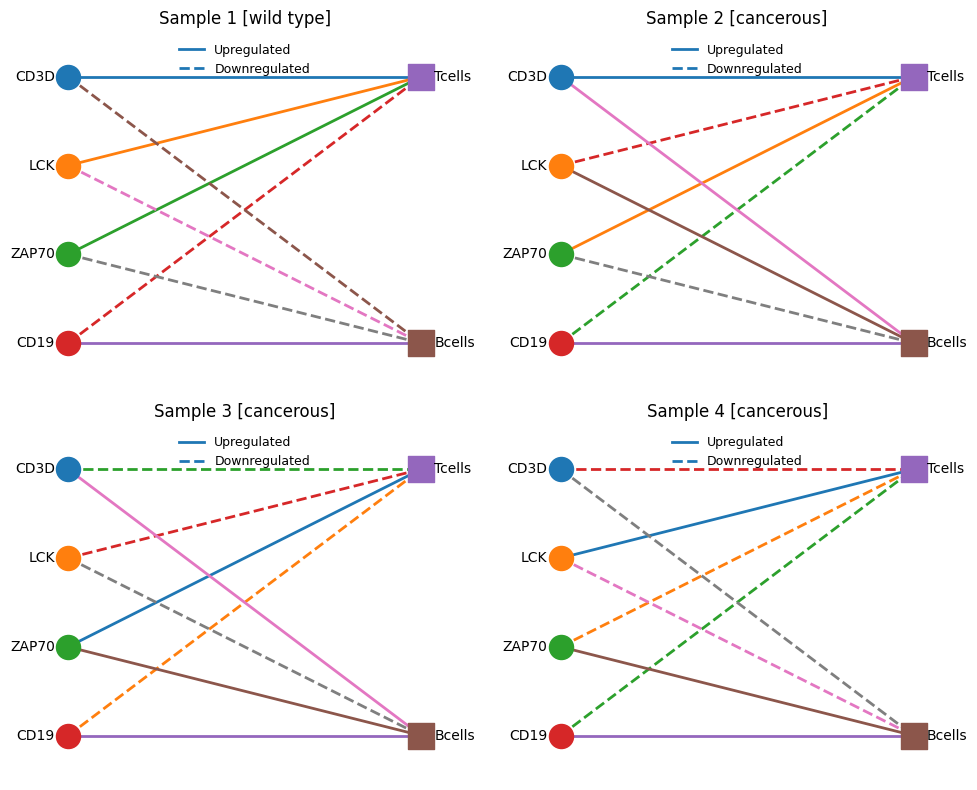

In [11]:
def compute_positions(genes, cell_types):
    # left column (genes), right column (cell types)
    gx, cx = 0.1, 0.9
    gy = list(range(len(genes)-1, -1, -1))  # top-to-bottom
    if len(cell_types) > 1:
        # spread CTs across same vertical span as genes
        span = (len(genes)-1)
        cy = [span * (1 - i/(len(cell_types)-1)) for i in range(len(cell_types))]
    else:
        cy = [(len(genes)-1)/2]
    pos = {g:(gx, gy[i]) for i,g in enumerate(genes)}
    pos.update({f"CT_{ct}":(cx, cy[j]) for j,ct in enumerate(cell_types)})
    return pos

def draw_sample(ax, spec, title, genes, cell_types):
    pos = compute_positions(genes, cell_types)
    # draw nodes
    for i,g in enumerate(genes):
        x,y = pos[g]
        ax.scatter([x],[y], s=300, marker='o', zorder=3)
        ax.text(x-0.03, y, g, va='center', ha='right', fontsize=10)
    for ct in cell_types:
        name = f"CT_{ct}"
        x,y = pos[name]
        ax.scatter([x],[y], s=350, marker='s', zorder=3)
        ax.text(x+0.03, y, ct, va='center', ha='left', fontsize=10)
    # draw edges: solid = upregulated (+1), dashed = downregulated (-1)
    for ct in cell_types:
        ct_name = f"CT_{ct}"
        for g in spec[ct].get('up', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='-', linewidth=2, zorder=2)
        for g in spec[ct].get('down', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='--', linewidth=2, zorder=2)

    # aesthetics
    ax.set_title(title)
    ax.set_xlim(0.0, 1.0)
    ys = list(range(len(genes)))
    ax.set_ylim(-0.5, len(genes)-0.5)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

    # legend (solid=up, dashed=down)
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0],[0], linestyle='-', linewidth=2, label='Upregulated'),
        Line2D([0],[0], linestyle='--', linewidth=2, label='Downregulated'),
    ]
    ax.legend(handles=legend_lines, loc='upper center', frameon=False, fontsize=9)

# ----- draw all four samples -----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
samples = [
    ('Sample 1 [wild type]',    wild_type),
    ('Sample 2 [cancerous]',    cancerous),
    ('Sample 3 [cancerous]',  cancerous_2),
    ('Sample 4 [cancerous]',  cancerous_3),
]
for ax, (name, spec) in zip(axes.ravel(), samples):
    draw_sample(ax, spec, name, genes, cell_types)

plt.tight_layout()
plt.show()

# Modeling

A machine learning model forward pass now uses the data prep information, runs several layers of linear algebra on it, and then "predicts" the probability of our different tasks, in this case the cell type based on the node and whether a graph is cancerous. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** - this step pulls from the raw data enough examples and batches to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass. 
2. **Forward Pass** - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** - using differentials we can understand what parameters most drive the difference between forward pass' impact on its prediction versus what is actually right based on the data loading step. We compare this based on the loss function and use the partial derivative gradients to make very minor adjustments to the impactful parameters with the hope it improves future predictions.

After our back prop, e'll show a final **Forward Pass** with the updated weights we did in #3 and then convert those final weights to a **Model Inference**

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset in a real experiment is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of node that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much context, or complexity, can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our batch to be our 4 examples, and nodes to the the nodes we have configured, 6. As we walk through you'll also see our GCN will have 2 layers to model 2 network hops: gene > cell type > other genes.

We'll prepare 2 sets of data. Our **Inputs** will be the `x_token`, or our list of nodes for each example, and `a_list`, our list of node connections.  Our **Outputs** will be `y_node`, our node level cell type identification, and `y_graph`, the graph level cancerous identification. 

**x_tokens** — list of nodes for each example. Each entry is an integer token id for the node at that position in node_order (e.g.`['CD3D','LCK','ZAP70','CD19','CT_Tcells','CT_Bcells']`).  In our case we you'll notice that each example contains all the nodes. 

In [12]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes, x_tokens

(4,
 6,
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-gene label for cell-type. `0` for T-cell marker and tie's, `1` for B-cell marker. As a reminder, this is an aggregation of the up-regulated and down-regulated genes. We focus on which cell type has the gene up-regulated and, if both have it, we use 0. There are ways to handle ties better but we won't get into it.  Since `y_node` also includes the cell types, we'll use -1 to mask them as ignored.

In [13]:
y_node.size(), y_node

(torch.Size([4, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1,  0,  0,  1, -1, -1],
         [ 0,  0,  1,  1, -1, -1]]))

**y_graph** — per-graph label for to determine if an example is cancerous. `0` is for wild_type and `1` is for cancerous.  

In [14]:
y_graph.size(), y_graph

(torch.Size([4]), tensor([0, 1, 1, 1]))

**A_list** - The relationships for each of our cells.  You'll notice here that only the last two ros and columns are used.  In this tensor `+1` is for **upregulated** gene per cell type and `-1` is for **downregulated**. `0` is for not in the network.  We also include here a **Gene_mask** that will act in our loss function as a flag to supress the gene x gene portions of the matrix. 

In [15]:
gene_mask, a_list

(tensor([ True,  True,  True,  True, False, False]),
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1., -1.,  1., -1.,  0.,  0.],
          [ 1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., -1.,  1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1.,  

### Data Loading - Signed Symmetric Graph Normalization

With `a_list` we now have all of our relationships but they're not in the most training conducive structure.  For our training, since we actually have 2 types of relationships, we need to split that into two different graphs that the model can learn across. This split creates 2 channels, 1 for the excitatory regulation, and one for the inhibitory.  We then run normalizaiton, and a self-loop on the excitory, to improve numerical stability, scaling, and preserve node signals to themself. Finally, once we've split and normalized each of the samples, we'll combine all of the same-signed tensors together into 1 large one using block-diagnola (which basically puts the graphs iteratively one after another diagnoally into one big tensor).  

Symmetric degree normalization bounds the propagation operator and removes degree bias. the split $A^{+}/A^{-}$ prevents destructive cancellation by a model trying to learn up and down regulation together, and lets the model learn different filters for up- vs down-regulation, self-loops in the positive channel allow each node to retain itsidentity. Finally block-diagonal stacking gives clean batching without cross-graph leakage. Fundamentally we apply:

$$
\tilde A = D^{-\tfrac12},\hat A,D^{-\tfrac12} \newline
\text{so}\\
\quad w_{ij}=\frac{\hat A_{ij}}{\sqrt{\deg_i,\deg_j}}.
$$

#### Signed Symmetric Graph Norm - First Example

Let's start with our first example. This one is our wild type.  The first step is to extract the network from the list.  

In [16]:
A = a_list[0]
A.size(), A

(torch.Size([6, 6]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [ 1.,  1.,  1., -1.,  0.,  0.],
         [-1., -1., -1.,  1.,  0.,  0.]]))

**Spliting** 

Now we'll split the network into the two different tensors, one for the positives and one for the negatives.  Recall that 0s are non-infromation for our training so we do not care where they go. 

In [17]:
A_pos = torch.clamp(A, min=0)  
A_neg = torch.clamp(-A, min=0)  
A_pos, A_neg

(tensor([[0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 0., -0., -0.]]))

**Self loop**

We'll now add the self-loop in. Adding a self-loop lets each node pass some of its own features forward, so its identity isn’t washed out by neighbors—especially when it has few or noisy connections. It acts like a tiny skip connection, stabilizing message passing and improving learning and gradient flow. We do need to be careful though to only include it on one split. If we put the self-loop in both channels, when we do our subraction during our forward pass, we'd add, then subtract a copy of the node’s own features every pass, which fights the residual/identity signal, shrinks or flips activations, and destabilizes training.

In [18]:
I = torch.eye(N_nodes)
A_pos_hat = A_pos + I # add for self looops 
A_neg_hat = A_neg
A_pos_hat, A_neg_hat

(tensor([[1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 1.],
         [1., 1., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 1.]]),
 tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 0., -0., -0.]]))

**Degree scaling**

As part of our normalization we divide by the squareroot of the product of the row and column sums.  We'll also add in a small epsilon to make sure we're not dividing by 0. We'll take this sum by graph then take the square roots. After that we'll create a diagonal so that we can take the dot product instead of having to worry about dimensions. 

In [19]:
deg_pos = torch.clamp(torch.abs(A_pos_hat).sum(1), min=1e-6)
deg_neg = torch.clamp(torch.abs(A_neg_hat).sum(1), min=1e-6)
deg_pos, deg_neg

(tensor([2., 2., 2., 2., 4., 2.]), tensor([1., 1., 1., 1., 1., 3.]))

In [20]:
D_pos_inv_sqrt = torch.diag(deg_pos.rsqrt())
D_neg_inv_sqrt = torch.diag(deg_neg.rsqrt())
D_pos_inv_sqrt, D_neg_inv_sqrt

(tensor([[0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071]]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774]]))

**Normalization**

Finally we'll do our normalization through our dot prod of the network with our inverse squareroot. 

In [21]:
Apos_n = D_pos_inv_sqrt @ A_pos_hat @ D_pos_inv_sqrt
Aneg_n = D_neg_inv_sqrt @ A_neg_hat @ D_neg_inv_sqrt
Apos_n, Aneg_n

(tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.5774, 0.5774, 0.5774, 0.0000, 0.0000, 0.0000]]))

**Bulk prep** 

Since we have 3 other samples to process, we'll create a list for aggregating the other normalization and add these into them. 

In [22]:
Apos_blk, Aneg_blk = [], []
Apos_blk.append(Apos_n)
Aneg_blk.append(Aneg_n)

#### Signed Symmetric Graph Norm - Remaining Example

Now that we've stepped through the first example, we'll do the same for the reamining three examples.  At the end we'll have normalized entries for all the examples split by sign. 

In [23]:
for A in a_list[1:]:
    A_pos = torch.clamp(A, min=0)  
    A_neg = torch.clamp(-A, min=0)  
    I = torch.eye(N_nodes)
    A_pos_hat = A_pos + I
    A_neg_hat = A_neg
    deg_pos = torch.clamp(torch.abs(A_pos_hat).sum(1), min=1e-6)
    deg_neg = torch.clamp(torch.abs(A_neg_hat).sum(1), min=1e-6)
    D_pos_inv_sqrt = torch.diag(deg_pos.rsqrt())
    D_neg_inv_sqrt = torch.diag(deg_neg.rsqrt())
    Apos_n = D_pos_inv_sqrt @ A_pos_hat @ D_pos_inv_sqrt
    Aneg_n = D_neg_inv_sqrt @ A_neg_hat @ D_neg_inv_sqrt
    Apos_blk.append(Apos_n)
    Aneg_blk.append(Aneg_n)

In [24]:
Apos_blk

[tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000]]),
 tensor([[0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.2887],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.4082, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.3536],
         [0.3333, 0.0000, 0.4082, 0.0000, 0.3333, 0.0000],
         [0.2887, 0.3536, 0.0000, 0.3536, 0.0000, 0.2500]]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3536],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3333, 0.0000, 0.4082, 0.2887],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.3536],
         [0.0000, 0.0000, 0.4082, 0.0000, 0.5000, 0.

In [25]:
Aneg_blk

[tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.5774, 0.5774, 0.5774, 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.4082, 0.7071],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000],
         [0.5774, 0.4082, 0.0000, 0.5774, 0.0000, 0.

#### Signed Symmetric Graph Norm - Block Diagonal

As our final step, we now join our netowrks together into. We do this using a block diagnoal join that creates a large tensor out of the inputs by simply sliding each new tensor to start at `[i+1,j+1]`.  In our our case this results in a `[24,24]` matrix since we have 4 examples with 6 nodes. 

In [26]:
Apos_blk =  torch.block_diag(*Apos_blk)
Apos_blk.size(), Apos_blk

(torch.Size([24, 24]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
   

In [27]:
Aneg_blk =  torch.block_diag(*Aneg_blk)
Aneg_blk.size(), Aneg_blk

(torch.Size([24, 24]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
   

## Forward pass

### Input Layer

In [28]:
n_embd = 3 # level of embedding of input tokens
vocab_size, n_embd

(6, 3)

#### Input Layer - Embedding Projection

In [29]:
tok_emb = nn.Embedding(vocab_size, n_embd)
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = tok_emb.num_embeddings, tok_emb.embedding_dim
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.01*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    tok_emb.weight.copy_(pattern)
tok_emb.weight

Parameter containing:
tensor([[0.0100, 0.0200, 0.0300],
        [0.0200, 0.0300, 0.0400],
        [0.0300, 0.0400, 0.0500],
        [0.0400, 0.0500, 0.0600],
        [0.0500, 0.0600, 0.0700],
        [0.0600, 0.0700, 0.0800]], requires_grad=True)

In [30]:
x = tok_emb(x_tokens)
x

tensor([[[0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800]],

        [[0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800]],

        [[0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800]],

        [[0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800]]], grad_fn=<EmbeddingBackward0>)

collapse out batch for learning

In [31]:
x = x.view(B_batch*N_nodes,n_embd)
x.size(), x

(torch.Size([24, 3]),
 tensor([[0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800],
         [0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800],
         [0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800],
         [0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800]], grad_fn=<ViewBackward0>))

### GCN Block

#### GCN Block - First Node Convolution

In [32]:
def pyramid_weight(h, w, base=0.01, dtype=torch.float32):
    r = torch.arange(h, dtype=dtype)
    c = torch.arange(w, dtype=dtype)
    drow = torch.minimum(r, (h - 1) - r)
    dcol = torch.minimum(c, (w - 1) - c)
    return base * (1 + drow)[:, None] * (1 + dcol)[None, :]

In [33]:
gcn_1_pos = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_1_pos.weight.copy_(pyramid_weight(n_embd, n_embd))
nn.init.constant_(gcn_1_pos.bias, 1e-6)
gcn_1_pos.weight, gcn_1_pos.bias

(Parameter containing:
 tensor([[0.0100, 0.0200, 0.0100],
         [0.0200, 0.0400, 0.0200],
         [0.0100, 0.0200, 0.0100]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [34]:
gcn_1_neg = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_1_neg.weight.copy_(pyramid_weight(n_embd, n_embd))
nn.init.constant_(gcn_1_neg.bias, 1e-6)
gcn_1_neg.weight, gcn_1_neg.bias

(Parameter containing:
 tensor([[0.0100, 0.0200, 0.0100],
         [0.0200, 0.0400, 0.0200],
         [0.0100, 0.0200, 0.0100]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [35]:
H_pos = Apos_blk @ x
H_pos

tensor([[0.0227, 0.0312, 0.0397],
        [0.0277, 0.0362, 0.0447],
        [0.0327, 0.0412, 0.0497],
        [0.0500, 0.0600, 0.0700],
        [0.0337, 0.0468, 0.0599],
        [0.0500, 0.0600, 0.0700],
        [0.0373, 0.0469, 0.0564],
        [0.0312, 0.0397, 0.0483],
        [0.0354, 0.0445, 0.0536],
        [0.0412, 0.0497, 0.0583],
        [0.0322, 0.0430, 0.0537],
        [0.0391, 0.0516, 0.0640],
        [0.0262, 0.0347, 0.0433],
        [0.0200, 0.0300, 0.0400],
        [0.0477, 0.0580, 0.0683],
        [0.0412, 0.0497, 0.0583],
        [0.0372, 0.0463, 0.0554],
        [0.0413, 0.0538, 0.0663],
        [0.0100, 0.0200, 0.0300],
        [0.0350, 0.0450, 0.0550],
        [0.0395, 0.0486, 0.0577],
        [0.0445, 0.0536, 0.0627],
        [0.0350, 0.0450, 0.0550],
        [0.0486, 0.0601, 0.0716]], grad_fn=<MmBackward0>)

In [36]:
H_pos =  gcn_1_pos(H_pos)
H_pos

tensor([[0.0012, 0.0025, 0.0012],
        [0.0014, 0.0029, 0.0014],
        [0.0016, 0.0033, 0.0016],
        [0.0024, 0.0048, 0.0024],
        [0.0019, 0.0037, 0.0019],
        [0.0024, 0.0048, 0.0024],
        [0.0019, 0.0038, 0.0019],
        [0.0016, 0.0032, 0.0016],
        [0.0018, 0.0036, 0.0018],
        [0.0020, 0.0040, 0.0020],
        [0.0017, 0.0034, 0.0017],
        [0.0021, 0.0041, 0.0021],
        [0.0014, 0.0028, 0.0014],
        [0.0012, 0.0024, 0.0012],
        [0.0023, 0.0046, 0.0023],
        [0.0020, 0.0040, 0.0020],
        [0.0019, 0.0037, 0.0019],
        [0.0022, 0.0043, 0.0022],
        [0.0008, 0.0016, 0.0008],
        [0.0018, 0.0036, 0.0018],
        [0.0019, 0.0039, 0.0019],
        [0.0021, 0.0043, 0.0021],
        [0.0018, 0.0036, 0.0018],
        [0.0024, 0.0048, 0.0024]], grad_fn=<AddmmBackward0>)

In [37]:
H_neg = Aneg_blk @ x
H_neg

tensor([[0.0346, 0.0404, 0.0462],
        [0.0346, 0.0404, 0.0462],
        [0.0346, 0.0404, 0.0462],
        [0.0500, 0.0600, 0.0700],
        [0.0400, 0.0500, 0.0600],
        [0.0346, 0.0520, 0.0693],
        [0.0000, 0.0000, 0.0000],
        [0.0354, 0.0424, 0.0495],
        [0.0600, 0.0700, 0.0800],
        [0.0354, 0.0424, 0.0495],
        [0.0424, 0.0566, 0.0707],
        [0.0300, 0.0400, 0.0500],
        [0.0289, 0.0346, 0.0404],
        [0.0628, 0.0740, 0.0851],
        [0.0000, 0.0000, 0.0000],
        [0.0289, 0.0346, 0.0404],
        [0.0370, 0.0527, 0.0683],
        [0.0141, 0.0212, 0.0283],
        [0.0504, 0.0595, 0.0686],
        [0.0424, 0.0495, 0.0566],
        [0.0289, 0.0346, 0.0404],
        [0.0289, 0.0346, 0.0404],
        [0.0445, 0.0601, 0.0758],
        [0.0191, 0.0312, 0.0433]], grad_fn=<MmBackward0>)

In [38]:
H_neg =  gcn_1_neg(H_neg)
H_neg

tensor([[1.6176e-03, 3.2342e-03, 1.6176e-03],
        [1.6176e-03, 3.2342e-03, 1.6176e-03],
        [1.6176e-03, 3.2342e-03, 1.6176e-03],
        [2.4010e-03, 4.8010e-03, 2.4010e-03],
        [2.0010e-03, 4.0010e-03, 2.0010e-03],
        [2.0795e-03, 4.1579e-03, 2.0795e-03],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.6981e-03, 3.3951e-03, 1.6981e-03],
        [2.8010e-03, 5.6010e-03, 2.8010e-03],
        [1.6981e-03, 3.3951e-03, 1.6981e-03],
        [2.2637e-03, 4.5265e-03, 2.2637e-03],
        [1.6010e-03, 3.2010e-03, 1.6010e-03],
        [1.3866e-03, 2.7723e-03, 1.3866e-03],
        [2.9607e-03, 5.9204e-03, 2.9607e-03],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.3866e-03, 2.7723e-03, 1.3866e-03],
        [2.1075e-03, 4.2140e-03, 2.1075e-03],
        [8.4953e-04, 1.6981e-03, 8.4953e-04],
        [2.3808e-03, 4.7606e-03, 2.3808e-03],
        [1.9809e-03, 3.9608e-03, 1.9809e-03],
        [1.3866e-03, 2.7723e-03, 1.3866e-03],
        [1.3866e-03, 2.7723e-03, 1

In [39]:
out = H_pos - H_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-3.6805e-04, -7.3611e-04, -3.6805e-04],
         [-1.6805e-04, -3.3611e-04, -1.6805e-04],
         [ 3.1947e-05,  6.3895e-05,  3.1947e-05],
         [-2.3283e-10, -4.6566e-10, -2.3283e-10],
         [-1.2721e-04, -2.5442e-04, -1.2721e-04],
         [ 3.2154e-04,  6.4308e-04,  3.2154e-04],
         [ 1.8750e-03,  3.7499e-03,  1.8750e-03],
         [-1.0711e-04, -2.1421e-04, -1.0711e-04],
         [-1.0202e-03, -2.0404e-03, -1.0202e-03],
         [ 2.9289e-04,  5.8579e-04,  2.9289e-04],
         [-5.4288e-04, -1.0858e-03, -5.4288e-04],
         [ 4.6231e-04,  9.2462e-04,  4.6231e-04],
         [ 4.3089e-06,  8.6178e-06,  4.3089e-06],
         [-1.7597e-03, -3.5194e-03, -1.7597e-03],
         [ 2.3214e-03,  4.6428e-03,  2.3214e-03],
         [ 6.0431e-04,  1.2086e-03,  6.0431e-04],
         [-2.5328e-04, -5.0656e-04, -2.5328e-04],
         [ 1.3033e-03,  2.6066e-03,  1.3033e-03],
         [-1.5798e-03, -3.1596e-03, -1.5798e-03],
         [-1.7990e-04, -3.59

#### GCN Block - First Batch Norm

In [40]:
bn_a = nn.LayerNorm(n_embd)
nn.init.constant_(bn_a.bias, 1e-6) # prevent 0 crashout
bn_a.weight, bn_a.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [41]:
out = bn_a(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 3.8739e-02, -7.7475e-02,  3.8739e-02],
         [ 1.7710e-02, -3.5417e-02,  1.7710e-02],
         [-3.3665e-03,  6.7360e-03, -3.3665e-03],
         [ 1.0245e-06,  9.5091e-07,  1.0245e-06],
         [ 1.3407e-02, -2.6812e-02,  1.3407e-02],
         [-3.3853e-02,  6.7710e-02, -3.3853e-02],
         [-1.9034e-01,  3.8069e-01, -1.9034e-01],
         [ 1.1290e-02, -2.2576e-02,  1.1290e-02],
         [ 1.0632e-01, -2.1263e-01,  1.0632e-01],
         [-3.0843e-02,  6.1689e-02, -3.0843e-02],
         [ 5.7039e-02, -1.1407e-01,  5.7039e-02],
         [-4.8616e-02,  9.7234e-02, -4.8616e-02],
         [-4.5320e-04,  9.0939e-04, -4.5320e-04],
         [ 1.7942e-01, -3.5883e-01,  1.7942e-01],
         [-2.3124e-01,  4.6249e-01, -2.3124e-01],
         [-6.3442e-02,  1.2689e-01, -6.3442e-02],
         [ 2.6680e-02, -5.3357e-02,  2.6680e-02],
         [-1.3486e-01,  2.6972e-01, -1.3486e-01],
         [ 1.6209e-01, -3.2418e-01,  1.6209e-01],
         [ 1.8957e-02, -3.79

#### GCN Block - Leaky ReLU

In [42]:
lrelu_1= nn.LeakyReLU(negative_slope=0.1)

In [43]:
out = lrelu_1(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 3.8739e-02, -7.7475e-03,  3.8739e-02],
         [ 1.7710e-02, -3.5417e-03,  1.7710e-02],
         [-3.3665e-04,  6.7360e-03, -3.3665e-04],
         [ 1.0245e-06,  9.5091e-07,  1.0245e-06],
         [ 1.3407e-02, -2.6812e-03,  1.3407e-02],
         [-3.3853e-03,  6.7710e-02, -3.3853e-03],
         [-1.9034e-02,  3.8069e-01, -1.9034e-02],
         [ 1.1290e-02, -2.2576e-03,  1.1290e-02],
         [ 1.0632e-01, -2.1263e-02,  1.0632e-01],
         [-3.0843e-03,  6.1689e-02, -3.0843e-03],
         [ 5.7039e-02, -1.1407e-02,  5.7039e-02],
         [-4.8616e-03,  9.7234e-02, -4.8616e-03],
         [-4.5320e-05,  9.0939e-04, -4.5320e-05],
         [ 1.7942e-01, -3.5883e-02,  1.7942e-01],
         [-2.3124e-02,  4.6249e-01, -2.3124e-02],
         [-6.3442e-03,  1.2689e-01, -6.3442e-03],
         [ 2.6680e-02, -5.3357e-03,  2.6680e-02],
         [-1.3486e-02,  2.6972e-01, -1.3486e-02],
         [ 1.6209e-01, -3.2418e-02,  1.6209e-01],
         [ 1.8957e-02, -3.79

#### GCN Block - Dropout

In [44]:
drop = torch.nn.Dropout(0.05)

In [45]:
out = drop(out) 
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 4.0778e-02, -8.1552e-03,  4.0778e-02],
         [ 1.8642e-02, -3.7281e-03,  1.8642e-02],
         [-3.5437e-04,  7.0905e-03, -3.5437e-04],
         [ 1.0785e-06,  1.0010e-06,  1.0785e-06],
         [ 0.0000e+00, -2.8223e-03,  1.4113e-02],
         [-3.5635e-03,  7.1273e-02, -3.5635e-03],
         [-2.0036e-02,  4.0072e-01, -2.0036e-02],
         [ 1.1884e-02, -2.3764e-03,  1.1884e-02],
         [ 1.1191e-01, -0.0000e+00,  1.1191e-01],
         [-3.2467e-03,  6.4936e-02, -3.2467e-03],
         [ 6.0041e-02, -1.2008e-02,  6.0041e-02],
         [-5.1174e-03,  1.0235e-01, -5.1174e-03],
         [-4.7705e-05,  9.5725e-04, -4.7705e-05],
         [ 1.8886e-01, -3.7772e-02,  1.8886e-01],
         [-2.4341e-02,  4.8683e-01, -2.4341e-02],
         [-6.6781e-03,  1.3356e-01, -6.6781e-03],
         [ 2.8084e-02, -5.6166e-03,  2.8084e-02],
         [-1.4196e-02,  2.8391e-01, -1.4196e-02],
         [ 1.7062e-01, -3.4124e-02,  1.7062e-01],
         [ 1.9955e-02, -3.99

#### GCN Block - Second Node Convolution

In [46]:
gcn_2_pos = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_2_pos.weight.copy_(pyramid_weight(n_embd, n_embd, base=0.05))
nn.init.constant_(gcn_2_pos.bias, 1e-6)
gcn_2_pos.weight, gcn_2_pos.bias

(Parameter containing:
 tensor([[0.0500, 0.1000, 0.0500],
         [0.1000, 0.2000, 0.1000],
         [0.0500, 0.1000, 0.0500]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [47]:
gcn_2_neg = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_2_neg.weight.copy_(pyramid_weight(n_embd, n_embd, base=0.05))
nn.init.constant_(gcn_2_neg.bias, 1e-6)
gcn_2_neg.weight, gcn_2_neg.bias

(Parameter containing:
 tensor([[0.0500, 0.1000, 0.0500],
         [0.1000, 0.2000, 0.1000],
         [0.0500, 0.1000, 0.0500]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [48]:
H2_pos = Apos_blk @ out
H2_pos.size(), H2_pos

(torch.Size([24, 3]),
 tensor([[ 2.0389e-02, -5.0755e-03,  2.5379e-02],
         [ 9.3209e-03, -2.8619e-03,  1.4311e-02],
         [-1.7718e-04,  2.5474e-03,  4.8126e-03],
         [-1.7812e-03,  3.5637e-02, -1.7812e-03],
         [ 2.0883e-02, -2.4001e-03,  2.4411e-02],
         [-1.7812e-03,  3.5637e-02, -1.7812e-03],
         [ 1.1858e-02,  1.5912e-01,  1.1858e-02],
         [ 4.1326e-03,  3.4999e-02,  4.1326e-03],
         [ 8.0468e-02, -4.9022e-03,  8.0468e-02],
         [-3.4326e-03,  6.8655e-02, -3.4326e-03],
         [ 5.9023e-02,  1.2957e-01,  5.9023e-02],
         [-4.0095e-03,  1.6338e-01, -4.0095e-03],
         [-5.0427e-03,  1.0086e-01, -5.0427e-03],
         [ 1.8886e-01, -3.7772e-02,  1.8886e-01],
         [-7.4628e-04,  2.4194e-01, -7.4628e-04],
         [-8.3579e-03,  1.6716e-01, -8.3579e-03],
         [ 4.1049e-03,  1.9594e-01,  4.1049e-03],
         [-1.2954e-02,  2.5908e-01, -1.2954e-02],
         [ 1.7062e-01, -3.4124e-02,  1.7062e-01],
         [ 4.3410e-02, -8.68

In [49]:
H2_pos =  gcn_2_pos(H2_pos)
H2_pos

tensor([[0.0018, 0.0036, 0.0018],
        [0.0009, 0.0018, 0.0009],
        [0.0005, 0.0010, 0.0005],
        [0.0034, 0.0068, 0.0034],
        [0.0020, 0.0041, 0.0020],
        [0.0034, 0.0068, 0.0034],
        [0.0171, 0.0342, 0.0171],
        [0.0039, 0.0078, 0.0039],
        [0.0076, 0.0151, 0.0076],
        [0.0065, 0.0130, 0.0065],
        [0.0189, 0.0377, 0.0189],
        [0.0159, 0.0319, 0.0159],
        [0.0096, 0.0192, 0.0096],
        [0.0151, 0.0302, 0.0151],
        [0.0241, 0.0482, 0.0241],
        [0.0159, 0.0318, 0.0159],
        [0.0200, 0.0400, 0.0200],
        [0.0246, 0.0492, 0.0246],
        [0.0137, 0.0273, 0.0137],
        [0.0035, 0.0069, 0.0035],
        [0.0156, 0.0313, 0.0156],
        [0.0177, 0.0355, 0.0177],
        [0.0035, 0.0069, 0.0035],
        [0.0193, 0.0385, 0.0193]], grad_fn=<AddmmBackward0>)

In [50]:
H2_neg = Aneg_blk @ out
H2_neg.size(), H2_neg

(torch.Size([24, 3]),
 tensor([[-2.0574e-03,  4.1150e-02, -2.0574e-03],
         [-2.0574e-03,  4.1150e-02, -2.0574e-03],
         [-2.0574e-03,  4.1150e-02, -2.0574e-03],
         [ 0.0000e+00, -2.8223e-03,  1.4113e-02],
         [ 1.0785e-06,  1.0010e-06,  1.0785e-06],
         [ 3.4101e-02, -2.7671e-03,  3.4101e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.2455e-02, -8.4908e-03,  4.2455e-02],
         [-5.1174e-03,  1.0235e-01, -5.1174e-03],
         [ 4.2455e-02, -8.4908e-03,  4.2455e-02],
         [ 6.1074e-03,  4.4236e-02,  6.1074e-03],
         [ 1.1191e-01,  0.0000e+00,  1.1191e-01],
         [ 1.6215e-02, -3.2427e-03,  1.6215e-02],
         [ 1.4277e-03,  1.9846e-01,  1.4277e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.6215e-02, -3.2427e-03,  1.6215e-02],
         [ 7.3219e-02,  6.2246e-02,  7.3219e-02],
         [ 1.3355e-01, -2.6709e-02,  1.3355e-01],
         [ 2.0985e-02,  1.2078e-01,  2.0985e-02],
         [-8.9267e-03,  1.78

In [51]:
H2_neg =  gcn_2_neg(H2_neg)
H2_neg

tensor([[3.9102e-03, 7.8194e-03, 3.9102e-03],
        [3.9102e-03, 7.8194e-03, 3.9102e-03],
        [3.9102e-03, 7.8194e-03, 3.9102e-03],
        [4.2442e-04, 8.4785e-04, 4.2442e-04],
        [1.2079e-06, 1.4159e-06, 1.2079e-06],
        [3.1344e-03, 6.2678e-03, 3.1344e-03],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [3.3974e-03, 6.7939e-03, 3.3974e-03],
        [9.7244e-03, 1.9448e-02, 9.7244e-03],
        [3.3974e-03, 6.7939e-03, 3.3974e-03],
        [5.0354e-03, 1.0070e-02, 5.0354e-03],
        [1.1192e-02, 2.2384e-02, 1.1192e-02],
        [1.2982e-03, 2.5954e-03, 1.2982e-03],
        [1.9990e-02, 3.9979e-02, 1.9990e-02],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.2982e-03, 2.5954e-03, 1.2982e-03],
        [1.3548e-02, 2.7094e-02, 1.3548e-02],
        [1.0685e-02, 2.1368e-02, 1.0685e-02],
        [1.4178e-02, 2.8355e-02, 1.4178e-02],
        [1.6962e-02, 3.3923e-02, 1.6962e-02],
        [3.0894e-03, 6.1778e-03, 3.0894e-03],
        [3.0894e-03, 6.1778e-03, 3

In [52]:
out = H2_pos - H2_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-0.0021, -0.0043, -0.0021],
         [-0.0030, -0.0060, -0.0030],
         [-0.0034, -0.0068, -0.0034],
         [ 0.0030,  0.0059,  0.0030],
         [ 0.0020,  0.0040,  0.0020],
         [ 0.0003,  0.0005,  0.0003],
         [ 0.0171,  0.0342,  0.0171],
         [ 0.0005,  0.0010,  0.0005],
         [-0.0022, -0.0043, -0.0022],
         [ 0.0031,  0.0063,  0.0031],
         [ 0.0138,  0.0277,  0.0138],
         [ 0.0047,  0.0095,  0.0047],
         [ 0.0083,  0.0166,  0.0083],
         [-0.0049, -0.0098, -0.0049],
         [ 0.0241,  0.0482,  0.0241],
         [ 0.0146,  0.0292,  0.0146],
         [ 0.0065,  0.0129,  0.0065],
         [ 0.0139,  0.0279,  0.0139],
         [-0.0005, -0.0011, -0.0005],
         [-0.0135, -0.0270, -0.0135],
         [ 0.0126,  0.0251,  0.0126],
         [ 0.0146,  0.0293,  0.0146],
         [-0.0180, -0.0360, -0.0180],
         [ 0.0113,  0.0226,  0.0113]], grad_fn=<SubBackward0>))

#### GCN Block - Second Batch Norm

In [53]:
bn_b = nn.LayerNorm(n_embd)
nn.init.constant_(bn_b.bias, 1e-6) # prevent 0 crashout
bn_b.weight, bn_b.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [54]:
out = bn_b(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 0.2138, -0.4277,  0.2138],
         [ 0.2898, -0.5796,  0.2898],
         [ 0.3214, -0.6427,  0.3214],
         [-0.2856,  0.5713, -0.2856],
         [-0.2043,  0.4086, -0.2043],
         [-0.0266,  0.0531, -0.0266],
         [-0.6583,  1.3165, -0.6583],
         [-0.0543,  0.1086, -0.0543],
         [ 0.2173, -0.4347,  0.2173],
         [-0.2987,  0.5973, -0.2987],
         [-0.6362,  1.2723, -0.6362],
         [-0.4084,  0.8168, -0.4084],
         [-0.5495,  1.0991, -0.5495],
         [ 0.4160, -0.8320,  0.4160],
         [-0.6812,  1.3625, -0.6812],
         [-0.6424,  1.2848, -0.6424],
         [-0.4904,  0.9808, -0.4904],
         [-0.6371,  1.2741, -0.6371],
         [ 0.0554, -0.1108,  0.0554],
         [ 0.6331, -1.2663,  0.6331],
         [-0.6237,  1.2474, -0.6237],
         [-0.6428,  1.2856, -0.6428],
         [ 0.6627, -1.3254,  0.6627],
         [-0.6081,  1.2161, -0.6081]], grad_fn=<NativeLayerNormBackward0>))

### Residual Connection

#### Residual Connection - Sum 

In [55]:
x = out + x
x.size(), x

(torch.Size([24, 3]),
 tensor([[ 0.2238, -0.4077,  0.2438],
         [ 0.3098, -0.5496,  0.3298],
         [ 0.3514, -0.6027,  0.3714],
         [-0.2456,  0.6213, -0.2256],
         [-0.1543,  0.4686, -0.1343],
         [ 0.0334,  0.1231,  0.0534],
         [-0.6483,  1.3365, -0.6283],
         [-0.0343,  0.1386, -0.0143],
         [ 0.2473, -0.3947,  0.2673],
         [-0.2587,  0.6473, -0.2387],
         [-0.5862,  1.3323, -0.5662],
         [-0.3484,  0.8868, -0.3284],
         [-0.5395,  1.1191, -0.5195],
         [ 0.4360, -0.8020,  0.4560],
         [-0.6512,  1.4025, -0.6312],
         [-0.6024,  1.3348, -0.5824],
         [-0.4404,  1.0408, -0.4204],
         [-0.5771,  1.3441, -0.5571],
         [ 0.0654, -0.0908,  0.0854],
         [ 0.6531, -1.2363,  0.6731],
         [-0.5937,  1.2874, -0.5737],
         [-0.6028,  1.3356, -0.5828],
         [ 0.7127, -1.2654,  0.7327],
         [-0.5481,  1.2861, -0.5281]], grad_fn=<AddBackward0>))

#### Residual Connection - Leaky ReLU 

In [56]:
lrelu_res = nn.LeakyReLU(negative_slope=0.1)

In [57]:
x = lrelu_res(x)
x.size(), x

(torch.Size([24, 3]),
 tensor([[ 0.2238, -0.0408,  0.2438],
         [ 0.3098, -0.0550,  0.3298],
         [ 0.3514, -0.0603,  0.3714],
         [-0.0246,  0.6213, -0.0226],
         [-0.0154,  0.4686, -0.0134],
         [ 0.0334,  0.1231,  0.0534],
         [-0.0648,  1.3365, -0.0628],
         [-0.0034,  0.1386, -0.0014],
         [ 0.2473, -0.0395,  0.2673],
         [-0.0259,  0.6473, -0.0239],
         [-0.0586,  1.3323, -0.0566],
         [-0.0348,  0.8868, -0.0328],
         [-0.0540,  1.1191, -0.0520],
         [ 0.4360, -0.0802,  0.4560],
         [-0.0651,  1.4025, -0.0631],
         [-0.0602,  1.3348, -0.0582],
         [-0.0440,  1.0408, -0.0420],
         [-0.0577,  1.3441, -0.0557],
         [ 0.0654, -0.0091,  0.0854],
         [ 0.6531, -0.1236,  0.6731],
         [-0.0594,  1.2874, -0.0574],
         [-0.0603,  1.3356, -0.0583],
         [ 0.7127, -0.1265,  0.7327],
         [-0.0548,  1.2861, -0.0528]], grad_fn=<LeakyReluBackward0>))

In [58]:
x = x.view(B_batch, N_nodes, n_embd)
x.size(), x

(torch.Size([4, 6, 3]),
 tensor([[[ 0.2238, -0.0408,  0.2438],
          [ 0.3098, -0.0550,  0.3298],
          [ 0.3514, -0.0603,  0.3714],
          [-0.0246,  0.6213, -0.0226],
          [-0.0154,  0.4686, -0.0134],
          [ 0.0334,  0.1231,  0.0534]],
 
         [[-0.0648,  1.3365, -0.0628],
          [-0.0034,  0.1386, -0.0014],
          [ 0.2473, -0.0395,  0.2673],
          [-0.0259,  0.6473, -0.0239],
          [-0.0586,  1.3323, -0.0566],
          [-0.0348,  0.8868, -0.0328]],
 
         [[-0.0540,  1.1191, -0.0520],
          [ 0.4360, -0.0802,  0.4560],
          [-0.0651,  1.4025, -0.0631],
          [-0.0602,  1.3348, -0.0582],
          [-0.0440,  1.0408, -0.0420],
          [-0.0577,  1.3441, -0.0557]],
 
         [[ 0.0654, -0.0091,  0.0854],
          [ 0.6531, -0.1236,  0.6731],
          [-0.0594,  1.2874, -0.0574],
          [-0.0603,  1.3356, -0.0583],
          [ 0.7127, -0.1265,  0.7327],
          [-0.0548,  1.2861, -0.0528]]], grad_fn=<ViewBackward0>))

### Output Layers AKA Model Head.

Instead of initializing weights this time around, we'll do **Weight Tying**.  Weight tying sets the output softmax matrix equal to the transpose of the input embedding matrix $W_{\text{out}} = W_e^\top$, forcing the model to “read” and “predict” in the same token space. This reduces parameters and acts as a useful prior, improving sample-efficiency and often perplexity by aligning input–output geometry. Modern LLMs have seemed to ditch this though to gain the extra capacity, but, for our example, we'll maintain it.


#### Output Layer - Node Head

For each of the 11 nodes, the model outputs a 2-vector of logits: [score_for_T, score_for_B].

In [59]:
node_head = nn.Linear(n_embd, 2, bias=True)   # cell-type logits per node
nn.init.constant_(node_head.weight, 0.1) 
nn.init.constant_(node_head.bias, 1e-6) # prevent 0 crashout
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [60]:
node_logits = node_head(x)   
node_logits.size(), node_logits

(torch.Size([4, 6, 2]),
 tensor([[[0.0427, 0.0427],
          [0.0585, 0.0585],
          [0.0662, 0.0662],
          [0.0574, 0.0574],
          [0.0440, 0.0440],
          [0.0210, 0.0210]],
 
         [[0.1209, 0.1209],
          [0.0134, 0.0134],
          [0.0475, 0.0475],
          [0.0598, 0.0598],
          [0.1217, 0.1217],
          [0.0819, 0.0819]],
 
         [[0.1013, 0.1013],
          [0.0812, 0.0812],
          [0.1274, 0.1274],
          [0.1216, 0.1216],
          [0.0955, 0.0955],
          [0.1231, 0.1231]],
 
         [[0.0142, 0.0142],
          [0.1203, 0.1203],
          [0.1171, 0.1171],
          [0.1217, 0.1217],
          [0.1319, 0.1319],
          [0.1179, 0.1179]]], grad_fn=<ViewBackward0>))

#### Output Layer - Graph Head

In [61]:
graph_head = nn.Linear(n_embd, 2, bias=True)  # cancer logits per graph
nn.init.constant_(graph_head.weight, 0.1) 
nn.init.constant_(graph_head.bias, 1e-6) # prevent 0 crashout
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [62]:
mask = gene_mask.float().unsqueeze(0)
mask.size(), mask

(torch.Size([1, 6]), tensor([[1., 1., 1., 1., 0., 0.]]))

In [63]:
denom = mask.sum(1, keepdim=True).clamp_min(1.0) 
denom

tensor([[4.]])

In [64]:
pooled = (x * mask.unsqueeze(-1)).sum(1) / denom   #[B,C]
pooled.size(), pooled

(torch.Size([4, 3]),
 tensor([[0.2151, 0.1163, 0.2306],
         [0.0383, 0.5207, 0.0448],
         [0.0642, 0.9440, 0.0707],
         [0.1497, 0.6226, 0.1607]], grad_fn=<DivBackward0>))

In [65]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([4, 2]),
 tensor([[0.0562, 0.0562],
         [0.0604, 0.0604],
         [0.1079, 0.1079],
         [0.0933, 0.0933]], grad_fn=<AddmmBackward0>))

## Loss calculation

In [66]:
losses = []

In [67]:
valid = (gene_mask & (y_node>=0))
valid

tensor([[ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False]])

**node loss**

For each of the 11 nodes, the model outputs a 2-vector of logits: [score_for_T, score_for_B].

In [68]:
node_logits[valid], y_node[valid]

(tensor([[0.0427, 0.0427],
         [0.0585, 0.0585],
         [0.0662, 0.0662],
         [0.0574, 0.0574],
         [0.1209, 0.1209],
         [0.0134, 0.0134],
         [0.0475, 0.0475],
         [0.0598, 0.0598],
         [0.1013, 0.1013],
         [0.0812, 0.0812],
         [0.1274, 0.1274],
         [0.1216, 0.1216],
         [0.0142, 0.0142],
         [0.1203, 0.1203],
         [0.1171, 0.1171],
         [0.1217, 0.1217]], grad_fn=<IndexBackward0>),
 tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]))

In [69]:
nl = F.cross_entropy(node_logits[valid], y_node[valid])
losses.append(nl)
nl

tensor(0.6931, grad_fn=<NllLossBackward0>)

**graph loss**

graph_logits: shape `[B, 2]` — one 2-class logit vector per graph (class 0 = wild_type, class 1 = cancerous).

In [70]:
graph_logits, y_graph

(tensor([[0.0562, 0.0562],
         [0.0604, 0.0604],
         [0.1079, 0.1079],
         [0.0933, 0.0933]], grad_fn=<AddmmBackward0>),
 tensor([0, 1, 1, 1]))

In [71]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.6931, grad_fn=<NllLossBackward0>)

In [72]:
loss = sum(losses) 
loss

tensor(1.3863, grad_fn=<AddBackward0>)

## Back Propagation

In [73]:
#output layers
graph_head.zero_grad()
node_head.zero_grad()

#GCN block
bn_b.zero_grad()
gcn_2_neg.zero_grad()
gcn_2_pos.zero_grad()
bn_a.zero_grad()
gcn_1_neg.zero_grad()
gcn_1_pos.zero_grad()

#input layer
tok_emb.zero_grad()

# validate gradients
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(None, None, None)

**Auto-Diff** - Now let's see the magic of the gradients populate.  This magic is called auto-differentiation, or auto-diff for short. This allows us to not have to write many layers of nasty code to do the differentiation for us, but, if you're a sadist, you can surely find people who have written out that code (it's not too bad since you just do one layer at a time). 

In [74]:
loss.backward()

In [75]:
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(tensor([[ 0.0046,  0.2464,  0.0057],
         [-0.0046, -0.2464, -0.0057]]),
 tensor([[-0.0764,  0.1298, -0.0805],
         [ 0.0764, -0.1298,  0.0805]]),
 tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]))

## Gradient Clipping

Recall that we discussed at the start that there was an issue called exploding gradients. Exploding gradients occurs because back-propagation through time multiplies gradients by a chain of recurrent Jacobians as follows:

$\nabla_{h_{t-k}} \mathcal{L} = \left(\prod_{i=1}^{k} \frac{\partial h_{t-i+1}}{\partial h_{t-i}}\right)\nabla_{h_t}\mathcal{L}$. 

This means that any spectral norm (>1) in those factors causes the gradient norm to grow roughly exponentially with sequence length. Even with LSTM gates, poorly conditioned hidden-to-hidden dynamics or large activations can push singular values WELL above 1 where even sigmoid and tanh layers will keep the values at 1. To combat this, we apply gradient clipping. Gradient clipping caps the global gradient, in our case to `1.0`, to prevent runaway steps, numerical overflow, and unstable updates.

*Note that this will only solve exploding gradients and does not address vanishing gradients. The LSTM structure and use of memory helps fight vanishing gradients*

Since none of our gradients are currently above 1, we will not see an impact of gradient clipping but I did want to introduce the concept as it is an important component. 

In [76]:
nn.utils.clip_grad_norm_(graph_head.parameters(), 1.0)
nn.utils.clip_grad_norm_(node_head.parameters(), 1.0)

nn.utils.clip_grad_norm_(bn_b.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_2_neg.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_2_pos.parameters(), 1.0)
nn.utils.clip_grad_norm_(bn_a.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_1_neg.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_1_pos.parameters(), 1.0)

nn.utils.clip_grad_norm_(tok_emb.parameters(), 1.0)

graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(tensor([[ 0.0046,  0.2464,  0.0057],
         [-0.0046, -0.2464, -0.0057]]),
 tensor([[-0.0764,  0.1298, -0.0805],
         [ 0.0764, -0.1298,  0.0805]]),
 tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]))

## Learning

The process of learning now requires us to update our weights based on this gradient. To really feel the "back propagation" we'll start with the last layer and work backwards, though, since we have all of the gradients calculated already, the order does not matter. Recall that our loss function is the negative log likelihood ratio so our gradient signs are flipped.  If a parameter is important, the gradient will be more negative, and vice versa. The gradients are a ratio of importance of each parameter and we need to know how much of that gradient to apply to our weights. This "how much" is referred to as the *learning rate*. In modern training learning rate schedulers and optimizers are used to vary the rate and application by layer and by training round with learning rates that are small (e.g. 1e-3) and decaying. 

We however are trying to learn and if you look at the gradient above in most layers it's tiny (~1e-10).  If we used a typical learning rate scheduler, with our context, batch size, and just 1 pass, the second pass would just have the same values and we wouldn't learn anything new.  Because of this we'll do something super unorthodox.  Our LM_head will use a learning rate of `1.000` but for the rest of the layers we'll use a learning rate of `1e7`. This INSANE learning rate would absolutely be too noisy for real training as taking that "large" of steps would mean the model could never find a good fit.  But since we're doing 1 step we don't care. Also, we're rerunning on the same example we used in the first loop so even less of a care. But as a warning, DO NOT DO THIS IN REAL TRAINING. If you did your model would most likely not converge. 

In [77]:
## Huge learning rate to emphasize
head_lr = 2.500
lr = 1e7

In [78]:
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(tensor([[ 0.0046,  0.2464,  0.0057],
         [-0.0046, -0.2464, -0.0057]]),
 tensor([[-0.0764,  0.1298, -0.0805],
         [ 0.0764, -0.1298,  0.0805]]),
 tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]))

### Output Layer
Let's start with our output layer.  Recall that we initialized the weights to `1.000` so we can quickly see the impact of the gradient update on the weights. Most notable that we'll see is that the entries corresponding with the token that are present in `y`, our target, are up weighted and others are downweighted. This should already intuitively give you a sense as to 
1. The model will be improved
2. This is WAY too high of a learning rate if we wanted to generalize.

Additionally you'll notice that the gradient is differs across the `n_embd` dimensions. This shows that even though we have done only a single pass, because we have multiple examples our model is already learning deeper structures. Finally, since this is the output layer, we did not include any bias 




In [79]:
with torch.no_grad():
    graph_head.weight -= head_lr * graph_head.weight.grad
    graph_head.bias -= graph_head.bias.grad
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[ 0.0884, -0.5160,  0.0858],
         [ 0.1116,  0.7160,  0.1142]], requires_grad=True),
 Parameter containing:
 tensor([-0.2500,  0.2500], requires_grad=True))

In [80]:
with torch.no_grad():
    node_head.weight -= head_lr * node_head.weight.grad
    node_head.bias -= node_head.bias.grad
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[ 0.2910, -0.2245,  0.3011],
         [-0.0910,  0.4245, -0.1011]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0625, -0.0625], requires_grad=True))

### GCN Unit - Main Pass

TO UPDATE

Next we'll update our two linear layers inside of the LSTM.  Recall that we initiated h2g to weights `0.2500`, x2g weights to `0.5000` and the biases to.  Our gradients on this layer are extremely small (~1e-9) and while the values are different across the embeddings, all are interestingly positive. This is starting to show how the different embedding layers can impact the recursion. 

With these layers you can see the beauty of our insanely high learning rate.  Even though our gradient impact was tiny, we can see the weight shift away from the initialization suggesting some level of adaptation. 

In [81]:
with torch.no_grad():
    bn_b.weight -= lr * bn_b.weight.grad
    bn_b.bias -= bn_b.bias.grad
bn_b.weight, bn_b.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [82]:
with torch.no_grad():
    gcn_2_neg.weight -= lr * gcn_2_neg.weight.grad
    gcn_2_neg.bias -= gcn_2_neg.bias.grad
gcn_2_neg.weight, gcn_2_neg.bias

(Parameter containing:
 tensor([[0.0500, 0.1000, 0.0500],
         [0.1000, 0.2000, 0.1000],
         [0.0500, 0.1000, 0.0500]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [83]:
with torch.no_grad():
    gcn_2_pos.weight -= lr * gcn_2_pos.weight.grad
    gcn_2_pos.bias -= gcn_2_pos.bias.grad
gcn_2_pos.weight, gcn_2_pos.bias

(Parameter containing:
 tensor([[0.0500, 0.1000, 0.0500],
         [0.1000, 0.2000, 0.1000],
         [0.0500, 0.1000, 0.0500]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [84]:
with torch.no_grad():
    bn_a.weight -= lr * bn_a.weight.grad
    bn_a.bias -= bn_a.bias.grad
bn_a.weight, bn_a.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [85]:
with torch.no_grad():
    gcn_1_neg.weight -= lr * gcn_1_neg.weight.grad
    gcn_1_neg.bias -= gcn_1_neg.bias.grad
gcn_1_neg.weight, gcn_1_neg.bias

(Parameter containing:
 tensor([[0.0100, 0.0200, 0.0100],
         [0.0200, 0.0400, 0.0200],
         [0.0100, 0.0200, 0.0100]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [86]:
with torch.no_grad():
    gcn_1_pos.weight -= lr * gcn_1_pos.weight.grad
    gcn_1_pos.bias -= gcn_1_pos.bias.grad
gcn_1_pos.weight, gcn_1_pos.bias

(Parameter containing:
 tensor([[0.0100, 0.0200, 0.0100],
         [0.0200, 0.0400, 0.0200],
         [0.0100, 0.0200, 0.0100]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

### Input Layer
No need as weight tying

In [87]:
with torch.no_grad():
    tok_emb.weight -= lr * tok_emb.weight.grad
tok_emb.weight

Parameter containing:
tensor([[0.0100, 0.0200, 0.0300],
        [0.0200, 0.0300, 0.0400],
        [0.0300, 0.0400, 0.0500],
        [0.0400, 0.0500, 0.0600],
        [0.0500, 0.0600, 0.0700],
        [0.0600, 0.0700, 0.0800]], requires_grad=True)

## Forward Pass with Updated Weights

Now that we have the updated weights for each layer, let's do another forward pass and compare the loss. Since each layer was previously explained we will instead focus on just showing the outputs of the different layers and the final loss. If you want, you can check the previous outputs in the cached cell outputs above and compare them to see how the weight changes impacted the values at each layer. 

You'll notice that because our high learning rate we're able to see how each layer now shifts the embedding values as the input passes through them. 

### Data Re-loading
since our tokens didn't go through we'll reuse them

In [88]:
x_tokens, y_node, y_graph, gene_mask

(tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1,  0,  0,  1, -1, -1],
         [ 0,  0,  1,  1, -1, -1]]),
 tensor([0, 1, 1, 1]),
 tensor([ True,  True,  True,  True, False, False]))

In [89]:
Apos_blk, Aneg_blk

(tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 

### Input Layer
Note that in `wte` since the gradient impact was only on the embeddings that mapped to our tokens. Lucky for us, we're passing the same example through so we'll pull those same weights.

With RNNs, because of the recursion layers, we would need long training and long context to see changes in our input layer initiation. Alternatively, a common step to help improve the input embedding is to do weight-tying between the input and output layers. This ensures that the input and output layers embed in the same space and helps with learning stabilization, but weight tying goes in and out of flavor often.  Because of this we'll cover weight-tying in the GPT notebook I write. 

In [90]:
x = tok_emb(x_tokens)
x = x.view(B_batch*N_nodes,n_embd)
x.size(), x

(torch.Size([24, 3]),
 tensor([[0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800],
         [0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800],
         [0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800],
         [0.0100, 0.0200, 0.0300],
         [0.0200, 0.0300, 0.0400],
         [0.0300, 0.0400, 0.0500],
         [0.0400, 0.0500, 0.0600],
         [0.0500, 0.0600, 0.0700],
         [0.0600, 0.0700, 0.0800]], grad_fn=<ViewBackward0>))

### GCN Block

### Recurrent Unit - LSTM

In [91]:
H_pos = Apos_blk @ x
H_pos =  gcn_1_pos(H_pos)
H_pos.size(), H_pos

(torch.Size([24, 3]),
 tensor([[0.0012, 0.0025, 0.0012],
         [0.0014, 0.0029, 0.0014],
         [0.0016, 0.0033, 0.0016],
         [0.0024, 0.0048, 0.0024],
         [0.0019, 0.0037, 0.0019],
         [0.0024, 0.0048, 0.0024],
         [0.0019, 0.0038, 0.0019],
         [0.0016, 0.0032, 0.0016],
         [0.0018, 0.0036, 0.0018],
         [0.0020, 0.0040, 0.0020],
         [0.0017, 0.0034, 0.0017],
         [0.0021, 0.0041, 0.0021],
         [0.0014, 0.0028, 0.0014],
         [0.0012, 0.0024, 0.0012],
         [0.0023, 0.0046, 0.0023],
         [0.0020, 0.0040, 0.0020],
         [0.0019, 0.0037, 0.0019],
         [0.0022, 0.0043, 0.0022],
         [0.0008, 0.0016, 0.0008],
         [0.0018, 0.0036, 0.0018],
         [0.0019, 0.0039, 0.0019],
         [0.0021, 0.0043, 0.0021],
         [0.0018, 0.0036, 0.0018],
         [0.0024, 0.0048, 0.0024]], grad_fn=<AddmmBackward0>))

In [92]:
H_neg = Aneg_blk @ x
H_neg =  gcn_1_neg(H_neg)
H_neg.size(), H_neg

(torch.Size([24, 3]),
 tensor([[1.6176e-03, 3.2342e-03, 1.6176e-03],
         [1.6176e-03, 3.2342e-03, 1.6176e-03],
         [1.6176e-03, 3.2342e-03, 1.6176e-03],
         [2.4010e-03, 4.8010e-03, 2.4010e-03],
         [2.0010e-03, 4.0010e-03, 2.0010e-03],
         [2.0795e-03, 4.1579e-03, 2.0795e-03],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.6981e-03, 3.3951e-03, 1.6981e-03],
         [2.8010e-03, 5.6010e-03, 2.8010e-03],
         [1.6981e-03, 3.3951e-03, 1.6981e-03],
         [2.2637e-03, 4.5265e-03, 2.2637e-03],
         [1.6010e-03, 3.2010e-03, 1.6010e-03],
         [1.3866e-03, 2.7723e-03, 1.3866e-03],
         [2.9607e-03, 5.9204e-03, 2.9607e-03],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.3866e-03, 2.7723e-03, 1.3866e-03],
         [2.1075e-03, 4.2140e-03, 2.1075e-03],
         [8.4953e-04, 1.6981e-03, 8.4953e-04],
         [2.3808e-03, 4.7606e-03, 2.3808e-03],
         [1.9809e-03, 3.9608e-03, 1.9809e-03],
         [1.3866e-03, 2.7723e-03, 1.38

In [93]:
out = H_pos - H_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-3.6805e-04, -7.3611e-04, -3.6805e-04],
         [-1.6805e-04, -3.3611e-04, -1.6805e-04],
         [ 3.1947e-05,  6.3895e-05,  3.1947e-05],
         [-2.3283e-10, -4.6566e-10, -2.3283e-10],
         [-1.2721e-04, -2.5442e-04, -1.2721e-04],
         [ 3.2154e-04,  6.4308e-04,  3.2154e-04],
         [ 1.8750e-03,  3.7499e-03,  1.8750e-03],
         [-1.0711e-04, -2.1421e-04, -1.0711e-04],
         [-1.0202e-03, -2.0404e-03, -1.0202e-03],
         [ 2.9289e-04,  5.8579e-04,  2.9289e-04],
         [-5.4288e-04, -1.0858e-03, -5.4288e-04],
         [ 4.6231e-04,  9.2462e-04,  4.6231e-04],
         [ 4.3089e-06,  8.6178e-06,  4.3089e-06],
         [-1.7597e-03, -3.5194e-03, -1.7597e-03],
         [ 2.3214e-03,  4.6428e-03,  2.3214e-03],
         [ 6.0431e-04,  1.2086e-03,  6.0431e-04],
         [-2.5328e-04, -5.0656e-04, -2.5328e-04],
         [ 1.3033e-03,  2.6066e-03,  1.3033e-03],
         [-1.5798e-03, -3.1596e-03, -1.5798e-03],
         [-1.7990e-04, -3.59

#### GCN Block - First Batch Norm

In [94]:
out = bn_a(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 3.8739e-02, -7.7475e-02,  3.8739e-02],
         [ 1.7710e-02, -3.5417e-02,  1.7710e-02],
         [-3.3665e-03,  6.7360e-03, -3.3665e-03],
         [ 1.0245e-06,  9.5091e-07,  1.0245e-06],
         [ 1.3407e-02, -2.6812e-02,  1.3407e-02],
         [-3.3853e-02,  6.7710e-02, -3.3853e-02],
         [-1.9034e-01,  3.8069e-01, -1.9034e-01],
         [ 1.1290e-02, -2.2576e-02,  1.1290e-02],
         [ 1.0632e-01, -2.1263e-01,  1.0632e-01],
         [-3.0843e-02,  6.1689e-02, -3.0843e-02],
         [ 5.7039e-02, -1.1407e-01,  5.7039e-02],
         [-4.8616e-02,  9.7234e-02, -4.8616e-02],
         [-4.5320e-04,  9.0939e-04, -4.5320e-04],
         [ 1.7942e-01, -3.5883e-01,  1.7942e-01],
         [-2.3124e-01,  4.6249e-01, -2.3124e-01],
         [-6.3442e-02,  1.2689e-01, -6.3442e-02],
         [ 2.6680e-02, -5.3357e-02,  2.6680e-02],
         [-1.3486e-01,  2.6972e-01, -1.3486e-01],
         [ 1.6209e-01, -3.2418e-01,  1.6209e-01],
         [ 1.8957e-02, -3.79

#### GCN Block - Leaky ReLU

In [95]:
out = lrelu_1(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 3.8739e-02, -7.7475e-03,  3.8739e-02],
         [ 1.7710e-02, -3.5417e-03,  1.7710e-02],
         [-3.3665e-04,  6.7360e-03, -3.3665e-04],
         [ 1.0245e-06,  9.5091e-07,  1.0245e-06],
         [ 1.3407e-02, -2.6812e-03,  1.3407e-02],
         [-3.3853e-03,  6.7710e-02, -3.3853e-03],
         [-1.9034e-02,  3.8069e-01, -1.9034e-02],
         [ 1.1290e-02, -2.2576e-03,  1.1290e-02],
         [ 1.0632e-01, -2.1263e-02,  1.0632e-01],
         [-3.0843e-03,  6.1689e-02, -3.0843e-03],
         [ 5.7039e-02, -1.1407e-02,  5.7039e-02],
         [-4.8616e-03,  9.7234e-02, -4.8616e-03],
         [-4.5320e-05,  9.0939e-04, -4.5320e-05],
         [ 1.7942e-01, -3.5883e-02,  1.7942e-01],
         [-2.3124e-02,  4.6249e-01, -2.3124e-02],
         [-6.3442e-03,  1.2689e-01, -6.3442e-03],
         [ 2.6680e-02, -5.3357e-03,  2.6680e-02],
         [-1.3486e-02,  2.6972e-01, -1.3486e-02],
         [ 1.6209e-01, -3.2418e-02,  1.6209e-01],
         [ 1.8957e-02, -3.79

#### GCN Block - Dropout

In [96]:
out = drop(out) 
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 4.0778e-02, -8.1552e-03,  4.0778e-02],
         [ 1.8642e-02, -3.7281e-03,  1.8642e-02],
         [-3.5437e-04,  7.0905e-03, -3.5437e-04],
         [ 1.0785e-06,  1.0010e-06,  1.0785e-06],
         [ 1.4113e-02, -2.8223e-03,  1.4113e-02],
         [-3.5635e-03,  7.1273e-02, -3.5635e-03],
         [-2.0036e-02,  4.0072e-01, -2.0036e-02],
         [ 1.1884e-02, -2.3764e-03,  1.1884e-02],
         [ 0.0000e+00, -2.2382e-02,  1.1191e-01],
         [-3.2467e-03,  6.4936e-02, -3.2467e-03],
         [ 6.0041e-02, -1.2008e-02,  0.0000e+00],
         [-5.1174e-03,  1.0235e-01, -0.0000e+00],
         [-4.7705e-05,  9.5725e-04, -4.7705e-05],
         [ 1.8886e-01, -3.7772e-02,  1.8886e-01],
         [-2.4341e-02,  4.8683e-01, -2.4341e-02],
         [-6.6781e-03,  1.3356e-01, -6.6781e-03],
         [ 0.0000e+00, -5.6166e-03,  2.8084e-02],
         [-1.4196e-02,  2.8391e-01, -1.4196e-02],
         [ 1.7062e-01, -3.4124e-02,  1.7062e-01],
         [ 1.9955e-02, -3.99

#### GCN Block - Second Node Convolution


In [97]:
H2_pos = Apos_blk @ out
H2_pos =  gcn_2_pos(H2_pos)
H2_pos.size(), H2_pos

(torch.Size([24, 3]),
 tensor([[0.0020, 0.0041, 0.0020],
         [0.0011, 0.0023, 0.0011],
         [0.0007, 0.0015, 0.0007],
         [0.0034, 0.0068, 0.0034],
         [0.0022, 0.0044, 0.0022],
         [0.0034, 0.0068, 0.0034],
         [0.0162, 0.0323, 0.0162],
         [0.0040, 0.0080, 0.0040],
         [0.0024, 0.0048, 0.0024],
         [0.0066, 0.0132, 0.0066],
         [0.0147, 0.0293, 0.0147],
         [0.0160, 0.0320, 0.0160],
         [0.0096, 0.0192, 0.0096],
         [0.0151, 0.0302, 0.0151],
         [0.0235, 0.0471, 0.0235],
         [0.0159, 0.0318, 0.0159],
         [0.0193, 0.0386, 0.0193],
         [0.0246, 0.0492, 0.0246],
         [0.0137, 0.0273, 0.0137],
         [0.0035, 0.0069, 0.0035],
         [0.0156, 0.0313, 0.0156],
         [0.0177, 0.0355, 0.0177],
         [0.0035, 0.0069, 0.0035],
         [0.0193, 0.0385, 0.0193]], grad_fn=<AddmmBackward0>))

In [98]:
H2_neg = Aneg_blk @ out
H2_neg =  gcn_2_neg(H2_neg)
H2_neg.size(), H2_neg

(torch.Size([24, 3]),
 tensor([[3.9102e-03, 7.8194e-03, 3.9102e-03],
         [3.9102e-03, 7.8194e-03, 3.9102e-03],
         [3.9102e-03, 7.8194e-03, 3.9102e-03],
         [1.1301e-03, 2.2592e-03, 1.1301e-03],
         [1.2079e-06, 1.4159e-06, 1.2079e-06],
         [3.1344e-03, 6.2678e-03, 3.1344e-03],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.2747e-03, 2.5484e-03, 1.2747e-03],
         [9.9803e-03, 1.9960e-02, 9.9803e-03],
         [1.2747e-03, 2.5484e-03, 1.2747e-03],
         [5.0354e-03, 1.0070e-02, 5.0354e-03],
         [3.3584e-03, 6.7158e-03, 3.3584e-03],
         [4.8745e-04, 9.7391e-04, 4.8745e-04],
         [1.9417e-02, 3.8833e-02, 1.9417e-02],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [4.8745e-04, 9.7391e-04, 4.8745e-04],
         [1.3548e-02, 2.7094e-02, 1.3548e-02],
         [1.0685e-02, 2.1368e-02, 1.0685e-02],
         [1.4178e-02, 2.8355e-02, 1.4178e-02],
         [1.6962e-02, 3.3923e-02, 1.6962e-02],
         [3.0894e-03, 6.1778e-03, 3.08

In [99]:
out = H2_pos - H2_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-0.0019, -0.0038, -0.0019],
         [-0.0028, -0.0055, -0.0028],
         [-0.0032, -0.0063, -0.0032],
         [ 0.0023,  0.0045,  0.0023],
         [ 0.0022,  0.0044,  0.0022],
         [ 0.0003,  0.0005,  0.0003],
         [ 0.0162,  0.0323,  0.0162],
         [ 0.0027,  0.0055,  0.0027],
         [-0.0076, -0.0151, -0.0076],
         [ 0.0053,  0.0107,  0.0053],
         [ 0.0096,  0.0193,  0.0096],
         [ 0.0126,  0.0253,  0.0126],
         [ 0.0091,  0.0182,  0.0091],
         [-0.0043, -0.0086, -0.0043],
         [ 0.0235,  0.0471,  0.0235],
         [ 0.0154,  0.0308,  0.0154],
         [ 0.0058,  0.0115,  0.0058],
         [ 0.0139,  0.0279,  0.0139],
         [-0.0005, -0.0011, -0.0005],
         [-0.0135, -0.0270, -0.0135],
         [ 0.0126,  0.0251,  0.0126],
         [ 0.0146,  0.0293,  0.0146],
         [-0.0180, -0.0360, -0.0180],
         [ 0.0113,  0.0226,  0.0113]], grad_fn=<SubBackward0>))

#### GCN Block - Second Batch Norm

In [100]:
out = bn_b(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 0.1907, -0.3814,  0.1907],
         [ 0.2694, -0.5388,  0.2694],
         [ 0.3024, -0.6047,  0.3024],
         [-0.2254,  0.4509, -0.2254],
         [-0.2204,  0.4409, -0.2204],
         [-0.0266,  0.0531, -0.0266],
         [-0.6531,  1.3063, -0.6531],
         [-0.2665,  0.5331, -0.2665],
         [ 0.5291, -1.0581,  0.5291],
         [-0.4403,  0.8807, -0.4403],
         [-0.5801,  1.1603, -0.5801],
         [-0.6246,  1.2493, -0.6246],
         [-0.5691,  1.1381, -0.5691],
         [ 0.3820, -0.7641,  0.3820],
         [-0.6800,  1.3601, -0.6800],
         [-0.6482,  1.2965, -0.6482],
         [-0.4605,  0.9209, -0.4605],
         [-0.6371,  1.2741, -0.6371],
         [ 0.0554, -0.1108,  0.0554],
         [ 0.6331, -1.2663,  0.6331],
         [-0.6237,  1.2474, -0.6237],
         [-0.6428,  1.2856, -0.6428],
         [ 0.6627, -1.3254,  0.6627],
         [-0.6081,  1.2161, -0.6081]], grad_fn=<NativeLayerNormBackward0>))

### Residual connection

#### Residual connection - connection

In [101]:
x = out + x
x.size(), x

(torch.Size([24, 3]),
 tensor([[ 0.2007, -0.3614,  0.2207],
         [ 0.2894, -0.5088,  0.3094],
         [ 0.3324, -0.5647,  0.3524],
         [-0.1854,  0.5009, -0.1654],
         [-0.1704,  0.5009, -0.1504],
         [ 0.0334,  0.1231,  0.0534],
         [-0.6431,  1.3263, -0.6231],
         [-0.2465,  0.5631, -0.2265],
         [ 0.5591, -1.0181,  0.5791],
         [-0.4003,  0.9307, -0.3803],
         [-0.5301,  1.2203, -0.5101],
         [-0.5646,  1.3193, -0.5446],
         [-0.5591,  1.1581, -0.5391],
         [ 0.4020, -0.7341,  0.4220],
         [-0.6500,  1.4001, -0.6300],
         [-0.6082,  1.3465, -0.5882],
         [-0.4105,  0.9809, -0.3905],
         [-0.5771,  1.3441, -0.5571],
         [ 0.0654, -0.0908,  0.0854],
         [ 0.6531, -1.2363,  0.6731],
         [-0.5937,  1.2874, -0.5737],
         [-0.6028,  1.3356, -0.5828],
         [ 0.7127, -1.2654,  0.7327],
         [-0.5481,  1.2861, -0.5281]], grad_fn=<AddBackward0>))

#### Residual connection - leaky relu

In [102]:
x = lrelu_res(x)
x = x.view(B_batch, N_nodes, n_embd)
x.size(), x

(torch.Size([4, 6, 3]),
 tensor([[[ 0.2007, -0.0361,  0.2207],
          [ 0.2894, -0.0509,  0.3094],
          [ 0.3324, -0.0565,  0.3524],
          [-0.0185,  0.5009, -0.0165],
          [-0.0170,  0.5009, -0.0150],
          [ 0.0334,  0.1231,  0.0534]],
 
         [[-0.0643,  1.3263, -0.0623],
          [-0.0247,  0.5631, -0.0227],
          [ 0.5591, -0.1018,  0.5791],
          [-0.0400,  0.9307, -0.0380],
          [-0.0530,  1.2203, -0.0510],
          [-0.0565,  1.3193, -0.0545]],
 
         [[-0.0559,  1.1581, -0.0539],
          [ 0.4020, -0.0734,  0.4220],
          [-0.0650,  1.4001, -0.0630],
          [-0.0608,  1.3465, -0.0588],
          [-0.0410,  0.9809, -0.0390],
          [-0.0577,  1.3441, -0.0557]],
 
         [[ 0.0654, -0.0091,  0.0854],
          [ 0.6531, -0.1236,  0.6731],
          [-0.0594,  1.2874, -0.0574],
          [-0.0603,  1.3356, -0.0583],
          [ 0.7127, -0.1265,  0.7327],
          [-0.0548,  1.2861, -0.0528]]], grad_fn=<ViewBackward0>))

### Output Head

#### Output Layer - Node Head

In [103]:
node_logits = node_head(x)   
node_logits.size(), node_logits

(torch.Size([4, 6, 2]),
 tensor([[[ 0.1955, -0.1184],
          [ 0.2513, -0.1417],
          [ 0.2780, -0.1524],
          [-0.0603,  0.1535],
          [-0.0594,  0.1532],
          [ 0.0607, -0.0187]],
 
         [[-0.2727,  0.5126],
          [-0.0779,  0.1811],
          [ 0.4224, -0.2152],
          [-0.1695,  0.3401],
          [-0.2422,  0.4655],
          [-0.2665,  0.5082]],
 
         [[-0.2300,  0.4397],
          [ 0.3231, -0.1729],
          [-0.2897,  0.5441],
          [-0.2752,  0.5205],
          [-0.1814,  0.3616],
          [-0.2728,  0.5190]],
 
         [[ 0.1093, -0.0809],
          [ 0.4830, -0.2425],
          [-0.2611,  0.4952],
          [-0.2724,  0.5158],
          [ 0.5189, -0.2552],
          [-0.2581,  0.4938]]], grad_fn=<ViewBackward0>))

#### Output Layer - Graph Head

In [104]:
mask = gene_mask.float().unsqueeze(0)
denom = mask.sum(1, keepdim=True).clamp_min(1.0) 
pooled = (x * mask.unsqueeze(-1)).sum(1) / denom 
pooled.size(), pooled

(torch.Size([4, 3]),
 tensor([[0.2010, 0.0893, 0.2165],
         [0.1075, 0.6796, 0.1140],
         [0.0551, 0.9578, 0.0616],
         [0.1497, 0.6226, 0.1607]], grad_fn=<DivBackward0>))

In [105]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([4, 2]),
 tensor([[-0.2598,  0.3611],
         [-0.5813,  0.7616],
         [-0.7340,  0.9489],
         [-0.5442,  0.7308]], grad_fn=<AddmmBackward0>))

### Updated Loss calculation

Now we'll calculate the updated loss.  Our first pass's loss was 3.5835, on par with random. Since we're passing through the same example and used a fairly high learning rate we should see a significant improvement with just 1 learning pass. 

In [106]:
loss

tensor(1.3863, grad_fn=<AddBackward0>)

#### node loss

In [107]:
losses = []
valid = (gene_mask & (y_node>=0))

In [108]:
nl = F.cross_entropy(node_logits[valid], y_node[valid])
losses.append(nl)
nl

tensor(0.5624, grad_fn=<NllLossBackward0>)

#### graph loss

In [109]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.4250, grad_fn=<NllLossBackward0>)

In [110]:
updated_loss = sum(losses) 
updated_loss

tensor(0.9873, grad_fn=<AddBackward0>)

In [111]:
f'1 round of training resulted in an loss improvment of {loss.item() - updated_loss.item():.4f}'

'1 round of training resulted in an loss improvment of 0.3990'

## Training SUCCESS!
Our training improved the loss by about **~28%** (amount may vary since we didn't set a seed). There are flaws with this, mainly passing the same example through a second time and a crazy high learning rate, but this helps show the fundamentals of what learning does inside a GCN style GNN model. 

In [112]:
print("Graph preds:", graph_logits.argmax(-1).tolist(), " True:", y_graph.tolist())

Graph preds: [1, 1, 1, 1]  True: [0, 1, 1, 1]


show prediction of which gene shows up in which cell upregulated more. If it's in both, you tie at "0" 

In [113]:
print("Per-node preds (genes only):")
label = {0: "T", 1: "B"}
pred = node_logits.argmax(-1)
ytrue = y_node
valid = (ytrue >= 0)
names = node_order


for b in range(pred.size(0)):
    idxs = torch.nonzero(valid[b], as_tuple=False).squeeze(1).tolist()
    parts = []
    for i in idxs:
        p = pred[b, i].item()
        t = ytrue[b, i].item()
        cor = '' if p ==  t else ' X'
        parts.append(f'{names[i]}: pred={label[p]} true={label[t]}{cor}')
    print(f'sample{b}: ' + ' | '.join(parts))

Per-node preds (genes only):
sample0: CD3D: pred=T true=T | LCK: pred=T true=T | ZAP70: pred=T true=T | CD19: pred=B true=B
sample1: CD3D: pred=B true=T X | LCK: pred=B true=B | ZAP70: pred=T true=T | CD19: pred=B true=B
sample2: CD3D: pred=B true=B | LCK: pred=T true=T | ZAP70: pred=B true=T X | CD19: pred=B true=B
sample3: CD3D: pred=T true=T | LCK: pred=T true=T | ZAP70: pred=B true=B | CD19: pred=B true=B


In [114]:
y_node

tensor([[ 0,  0,  0,  1, -1, -1],
        [ 0,  1,  0,  1, -1, -1],
        [ 1,  0,  0,  1, -1, -1],
        [ 0,  0,  1,  1, -1, -1]])